In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Reading the extracted data

In [4]:
df = pd.read_csv(r'C:\Aditya\Research Work\Time-series-forecasting\extracted important\AshokNagar_extracted.csv')
print(df.head())


          From Date           To Date   PM2.5    PM10     NO    NO2     NOx  \
0  01-01-2017 00:00  01-01-2017 00:30  162.00  227.00  19.52  85.08  102.48   
1  01-01-2017 00:30  01-01-2017 01:00  162.00  227.00  51.35  83.50  144.55   
2  01-01-2017 01:00  01-01-2017 01:30  162.00  227.00  57.88  87.60  157.08   
3  01-01-2017 01:30  01-01-2017 02:00  168.33  225.33  41.17  79.98  127.48   
4  01-01-2017 02:00  01-01-2017 02:30  181.00  222.00  60.93  78.53  153.20   

      NH3    SO2    CO  ...  Toluene  Temp     RH    WS      WD     SR     BP  \
0   86.52  21.33  1.95  ...    21.20   NaN  71.83  1.28  107.17  12.50  740.0   
1  115.87  21.70  1.94  ...    17.70   NaN  71.83  0.57  147.33  12.00  740.0   
2  123.35  22.18  2.20  ...    12.50   NaN  73.00  0.70  118.00  12.17  740.0   
3  126.48  21.33  2.12  ...    18.65   NaN  73.50  0.32   89.00  12.17  740.0   
4  122.20  21.77  2.00  ...    16.65   NaN  74.83  0.95   95.33  12.33  740.0   

      AT  RF  TOT-RF  
0  14.75 NaN   

# Filtering data for 31st December 2023 for prediction of AQI for 1st January 2024

In [5]:
# Convert the 'From Date' column to datetime format
df['From Date'] = pd.to_datetime(df['From Date'], format='%d-%m-%Y %H:%M')

# Filter the dataframe for rows with 'From Date' equal to 1st January 2024
filtered_df = df[df['From Date'].dt.date == pd.to_datetime('2023-12-31').date()]

# Save the filtered dataframe to a separate file
filtered_df.to_csv('filtered_data.csv', index=False)


In [6]:
df_new = pd.read_csv('filtered_data.csv')

### Keeping only those columns whose significane in AQI is known and best for prediction

In [7]:
columns_to_keep = ['From Date','PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone','NH3']
df_new = df_new[columns_to_keep]


In [8]:
df_new.head()

,From Date,PM2.5,PM10,NO2,SO2,CO,Ozone,NH3
0,2023-12-31 00:00:00,262.0,381.0,54.70,7.35,2.03,15.15,22.00
1,2023-12-31 00:30:00,260.0,375.5,71.20,6.15,2.17,15.10,29.55
2,2023-12-31 01:00:00,258.0,370.0,78.00,8.10,2.04,15.85,26.80
3,2023-12-31 01:30:00,251.5,367.0,68.45,6.70,2.05,22.65,30.25
4,2023-12-31 02:00:00,245.0,364.0,65.25,5.30,1.96,27.25,35.55


### Arranging the parameters in an array for future use

In [9]:
import csv

def read_filtered_data(filename):
    data = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append({
                'PM2.5': row['PM2.5'],
                'PM10': row['PM10'],
                'NO2': row['NO2'],
                'SO2': row['SO2'],
                'CO': row['CO'],
                'Ozone': row['Ozone'],
                'NH3':row['NH3']
            })
    return data

filtered_data = read_filtered_data('filtered_data.csv')
# len(filtered_data)
filtered_data



[{'PM2.5': '262.0',
  'PM10': '381.0',
  'NO2': '54.7',
  'SO2': '7.35',
  'CO': '2.03',
  'Ozone': '15.15',
  'NH3': '22.0'},
 {'PM2.5': '260.0',
  'PM10': '375.5',
  'NO2': '71.2',
  'SO2': '6.15',
  'CO': '2.17',
  'Ozone': '15.1',
  'NH3': '29.55'},
 {'PM2.5': '258.0',
  'PM10': '370.0',
  'NO2': '78.0',
  'SO2': '8.1',
  'CO': '2.04',
  'Ozone': '15.85',
  'NH3': '26.8'},
 {'PM2.5': '251.5',
  'PM10': '367.0',
  'NO2': '68.45',
  'SO2': '6.7',
  'CO': '2.05',
  'Ozone': '22.65',
  'NH3': '30.25'},
 {'PM2.5': '245.0',
  'PM10': '364.0',
  'NO2': '65.25',
  'SO2': '5.3',
  'CO': '1.96',
  'Ozone': '27.25',
  'NH3': '35.55'},
 {'PM2.5': '242.0',
  'PM10': '351.5',
  'NO2': '62.75',
  'SO2': '2.65',
  'CO': '1.96',
  'Ozone': '29.3',
  'NH3': '42.9'},
 {'PM2.5': '239.0',
  'PM10': '339.0',
  'NO2': '62.5',
  'SO2': '4.15',
  'CO': '1.91',
  'Ozone': '29.3',
  'NH3': '35.25'},
 {'PM2.5': '239.0',
  'PM10': '342.0',
  'NO2': '61.65',
  'SO2': '3.95',
  'CO': '1.88',
  'Ozone': '28.75',


## Referring to https://pib.gov.in/newsite/printrelease.aspx?relid=110654 for PM2.5, PM10, NO2, SO2, CO, ozone

### I = [(IHI - ILO) / (BPHI - BPLO)] * (C - BPLO) + ILO formula AQI subindex

## Identifying BPHI and BPLO for each parameter

In [10]:
max_values = df_new.max()
min_values = df_new.min()

pm25_max = max_values['PM2.5']
pm25_min = min_values['PM2.5']
pm10_max = max_values['PM10']
pm10_min = min_values['PM10']
no2_max = max_values['NO2']
no2_min = min_values['NO2']
so2_max = max_values['SO2']
so2_min = min_values['SO2']
co_max = max_values['CO']
co_min = min_values['CO']
ozone_max = max_values['Ozone']
ozone_min = min_values['Ozone']
nh3_max = max_values['NH3']
nh3_min = min_values['NH3']


In [11]:
print('PM2.5 Max:', pm25_max, 'PM2.5 Min:', pm25_min, 'PM10 Max:', pm10_max, 'PM10 Min:', pm10_min, 'NO2 Max:', no2_max, 'NO2 Min:', no2_min, 'SO2 Max:', so2_max, 'SO2 Min:', so2_min, 'CO Max:', co_max, 'CO Min:', co_min, 'Ozone Max:', ozone_max, 'Ozone Min:', ozone_min,'NH3 Max:', nh3_max, 'NH3 Min:', nh3_min)

PM2.5 Max: 309.0 PM2.5 Min: 158.0 PM10 Max: 462.0 PM10 Min: 248.0 NO2 Max: 89.95 NO2 Min: 43.1 SO2 Max: 31.8 SO2 Min: 2.65 CO Max: 2.26 CO Min: 1.5 Ozone Max: 30.75 Ozone Min: 15.1 NH3 Max: 42.9 NH3 Min: 10.95


### Identifying the average of each parameter for the day to know the IHi and ILo ranges

In [12]:
average_pm25 = df_new['PM2.5'].mean()
average_pm10 = df_new['PM10'].mean()
average_no2 = df_new['NO2'].mean()
average_so2 = df_new['SO2'].mean()

average_nh3 = df_new['NH3'].mean()





### Ozone is sampled every 8 hours, so the average of the 3 samples is taken for the day

In [13]:
df_new['From Date'] = pd.to_datetime(df_new['From Date'])
ozone_8hr_avg = df_new.set_index('From Date').resample('8H')['Ozone'].mean().reset_index()
print(ozone_8hr_avg)


            From Date      Ozone
0 2023-12-31 00:00:00  25.315625
1 2023-12-31 08:00:00  19.221875
2 2023-12-31 16:00:00  17.990625


C:\Users\jetha\AppData\Local\Temp\ipykernel_29848\3075675172.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ozone_8hr_avg = df_new.set_index('From Date').resample('8H')['Ozone'].mean().reset_index()


### CO is sampled every 8 hours, so the average of the 3 samples is taken for the day

In [14]:
df_new['From Date'] = pd.to_datetime(df_new['From Date'])
co_8hr_avg = df_new.set_index('From Date').resample('8H')['CO'].mean().reset_index()
print(co_8hr_avg)

            From Date        CO
0 2023-12-31 00:00:00  1.906250
1 2023-12-31 08:00:00  2.103125
2 2023-12-31 16:00:00  1.750000


C:\Users\jetha\AppData\Local\Temp\ipykernel_29848\3633202141.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  co_8hr_avg = df_new.set_index('From Date').resample('8H')['CO'].mean().reset_index()


#### printing the average of each parameter for the day (except ozone and CO)

In [15]:
print("Avg PM2.5: ", average_pm25,"Avg PM10: ", average_pm10,"Avg NO2: ", average_no2,"Avg SO2: ", average_so2,"Avg NH3: ", average_nh3)

Avg PM2.5:  238.45833333333334 Avg PM10:  364.2395833333333 Avg NO2:  66.30833333333334 Avg SO2:  9.5625 Avg NH3:  24.87395833333333


Based on the average and the AQI range suggested from the above link the formula variables are as follows:
For PM2.5 : 238.458, IHi=400, ILo=301, BPHI=250, BPLO=121
For PM10 : 364.239, IHi=400, ILo=301, BPHI=430, BPLO=351
For NO2 : 66.308, IHi=100, ILo=51, BPHI=80, BPLO=41
For SO2 : 9.562, IHi=50, ILo=0, BPHI=40, BPLO=0
For CO : (Overall AVG: 1.919), IHi=100, ILo=51, BPHI=2, BPLO=1.1
For Ozone : (Overall AVG: 20.84), IHi=50, ILo=0, BPHI=50, BPLO=0

### Calculating Subindex for each parameter

In [16]:
def calculate_subindex(pollutant_data):
    """Calculates the AQI sub-index for a given pollutant.

    Args:
        pollutant_data: A dictionary containing the pollutant's concentration (C),
                        breakpoint values (BPHI, BPLO), and index limits (IHI, ILo).

    Returns:
        The calculated AQI sub-index.
    """

    C = pollutant_data["C"]
    BPHI = pollutant_data["BPHI"]
    BPLO = pollutant_data["BPLO"]
    IHi = pollutant_data["IHi"]
    ILo = pollutant_data["ILo"]

    # Use the AQI formula 
    subindex = ((IHi - ILo) / (BPHI - BPLO)) * (C - BPLO) + ILo

    return round(subindex, 2)  # Round to two decimal places

# Your manually observed data
data = {
    "PM2.5": {
        "C": 238.458,
        "IHi": 400,
        "ILo": 301,
        "BPHI": 250,
        "BPLO": 121
    },
    "PM10": {
        "C": 364.239,
        "IHi": 400,
        "ILo": 301,
        "BPHI": 430,
        "BPLO": 351
    },
    "NO2": {
        "C": 66.308,
        "IHi": 100,
        "ILo": 51,
        "BPHI": 80,
        "BPLO": 41
    },
    "SO2": {
        "C": 9.562,
        "IHi": 50,
        "ILo": 0,
        "BPHI": 40,
        "BPLO": 0
    },
    "CO": {
        "C": 1.919,  # Assuming overall average
        "IHi": 100,
        "ILo": 51,
        "BPHI": 2,
        "BPLO": 1.1
    },
    "O3": {
        "C": 20.84,  # Assuming overall average
        "IHi": 50,
        "ILo": 0,
        "BPHI": 50,
        "BPLO": 0
    }
}

# Calculate and print the sub-indexes
for pollutant, pollutant_data in data.items():
    subindex = calculate_subindex(pollutant_data)
    print(f"{pollutant}: {subindex}")


PM2.5: 391.14
PM10: 317.59
NO2: 82.8
SO2: 11.95
CO: 95.59
O3: 20.84


We Observe that the PM2.5 and PM10 are the highest among the pollutants. So, we declare the AQI based on PM2.5

## AQI for 31st December 2023 is 391.14

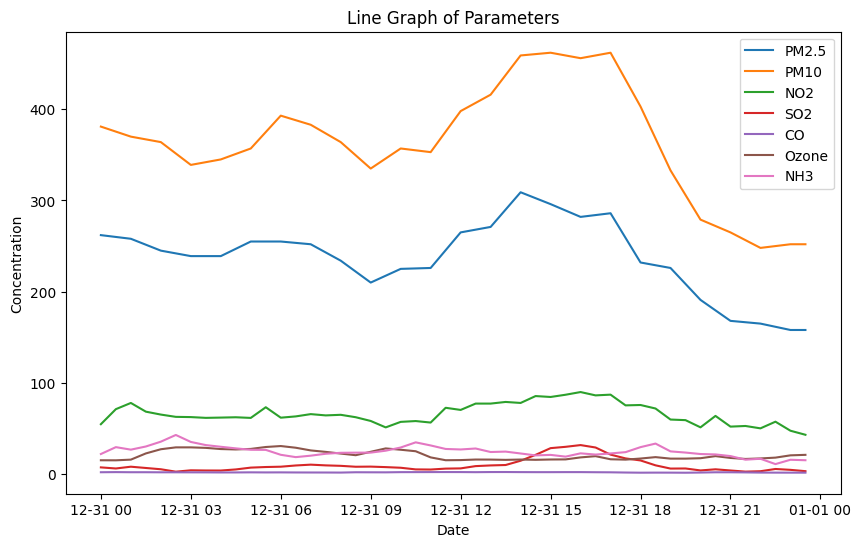

In [17]:
# Plotting line graph for each parameter
plt.figure(figsize=(10, 6))

# PM2.5
plt.plot(df_new['From Date'], df_new['PM2.5'], label='PM2.5')

# PM10
plt.plot(df_new['From Date'], df_new['PM10'], label='PM10')

# NO2
plt.plot(df_new['From Date'], df_new['NO2'], label='NO2')

# SO2
plt.plot(df_new['From Date'], df_new['SO2'], label='SO2')

# CO
plt.plot(df_new['From Date'], df_new['CO'], label='CO')

# Ozone
plt.plot(df_new['From Date'], df_new['Ozone'], label='Ozone')

# NH3
plt.plot(df_new['From Date'], df_new['NH3'], label='NH3')

# Set x-axis label
plt.xlabel('Date')

# Set y-axis label
plt.ylabel('Concentration')

# Set title
plt.title('Line Graph of Parameters')

# Add legend
plt.legend()

# Show the plot
plt.show()
